In this notebook I will determine the fiducial HOD parameters that are consistent with best-fits from the literature *and* is not impacted by the halo mass limit of the HADES and Quijote simulations. 

In [1]:
import os 
import scipy as sp 
import numpy as np 
# --- eMaNu --- 
from emanu import util as UT
from emanu import forwardmodel as FM
from emanu.hades import data as hadesData
# -- pyspectrum -- 
from pyspectrum import pyspectrum as pySpec
# --- corrfunc -- 
from Corrfunc.theory import wp as wpCF

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline 

In [3]:
# halo catalogs 
halos = hadesData.hadesMnuHalos(0., 1, 4, mh_min=None, dir='/Users/ChangHoon/data/emanu/halos/hades/0.0eV/1')
Mh_min = np.log10(np.array(halos['Mass']).min()) 
# hi res halo catalog
halos_hires = hadesData.hadesMnuHalos(0., '1_hires', 4, mh_min=None, dir='/Users/ChangHoon/data/emanu/halos/hades/0.0eV/1_hires')

In [4]:
# Zheng et al. halo occupation functions 
def Ncen_Mh(tt, logMh): 
    ''' expected Ncen at Mh 
    '''
    logMmin, sig_logM, _, _, _ = tt
    Ncen = 0.5 * (1. + sp.special.erf((logMh - logMmin)/sig_logM)) 
    Ncen[~np.isfinite(Ncen)] = 0. 
    return Ncen

def Nsat_Mh(tt, logMh): 
    ''' expected Nsat at Mh
    '''
    _Ncen = Ncen_Mh(tt, logMh) 
    _, _, logM0, alpha, logM1 = tt
    Nsat = _Ncen * ((10**logMh - 10**logM0)/10**logM1)**alpha
    Nsat[~np.isfinite(Nsat)] = 0. 
    return Nsat 

def Ngal_Mh(tt, logMh): 
    return Ncen_Mh(tt, logMh) + Nsat_Mh(tt, logMh)

Here's how the best-fits from the literature compare to one another 

In [5]:
z07_21_5 = np.array([13.38, 0.51, 13.94, 1.04, 13.91]) # Zheng+(2007) Mr<-21.5
g15_21_5 = np.array([13.53, 0.72, 13.13, 1.14, 14.52]) # Guo+(2015) Mr<-21.5
v19_21_5 = np.array([13.39, 0.56, 12.87, 1.26, 14.51]) # Vakili+(2019) Mr<-21.5
z07_22_0 = np.array([14.22, 0.77, 14.00, 0.87, 14.69]) # Zheng+(2007) Mr<-22

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


(0.01, 50.0)

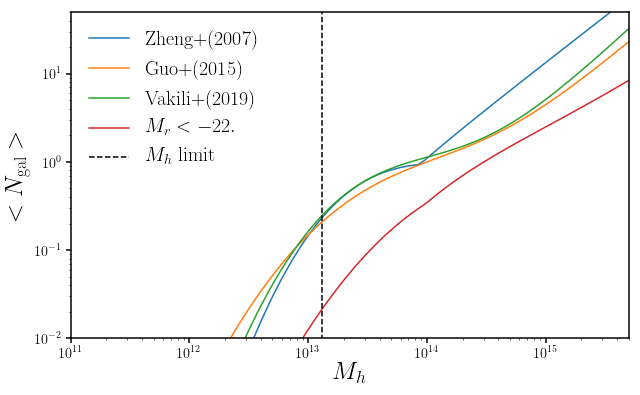

In [6]:
logMbin = np.linspace(11., 16., 100) # logMh bins

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.plot(10**logMbin, Ngal_Mh(z07_21_5, logMbin), label='Zheng+(2007)')
sub.plot(10**logMbin, Ngal_Mh(g15_21_5, logMbin), label='Guo+(2015)')
sub.plot(10**logMbin, Ngal_Mh(v19_21_5, logMbin), label='Vakili+(2019)')
sub.plot(10**logMbin, Ngal_Mh(z07_22_0, logMbin), label='$M_r < -22.$')
sub.plot([10**Mh_min, 10**Mh_min], [1e-3, 1e3], c='k', ls='--', label='$M_h$ limit')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('$M_h$', fontsize=25)
sub.set_xscale('log')
sub.set_xlim(1e11, 5e15)
sub.set_ylabel(r'$<N_{\rm gal}>$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e-2, 5e1)

Based on the halo mass limit, the $M_r < -21.5$ SDSS sample best-fit HODs cannot be reliably used. Lets confirm this by comparing the galaxy clustering for the HODs using the regular simulations and higher resolution simulations. 

In [7]:
def pk_model(halos, tt, rsd=True, seed=None): 
    ''' wrapper for populating halos and calculating Pk 
    '''
    # population halos 
    hod = FM.hodGalaxies(halos, {'logMmin': tt[0], 'sigma_logM': tt[1], 'logM0': tt[2], 'alpha': tt[3], 'logM1': tt[4]}, seed=seed)
    # apply RSD 
    if rsd: xyz = FM.RSD(hod) 
    else: xyz = np.array(hod['Position']) 
    # calculate wp 
    _pk = pySpec.Pk_periodic(xyz.T, Lbox=1000, Ngrid=360, fft='pyfftw', silent=True)
    return _pk['k'], _pk['p0k']

rbins = np.array([0.1, 0.15848932, 0.25118864, 0.39810717, 0.63095734, 1., 1.58489319, 2.51188643, 3.98107171, 6.30957344, 10., 15.84893192, 25.11886432]) 
def wp_model(halos, tt, rsd=True, seed=None): 
    ''' wrapper for populating halos and calculating wp 
    '''
    # population halos 
    hod = FM.hodGalaxies(halos, {'logMmin': tt[0], 'sigma_logM': tt[1], 'logM0': tt[2], 'alpha': tt[3], 'logM1': tt[4]}, seed=seed) 
    # apply RSD 
    if rsd: xyz = FM.RSD(hod) 
    else: xyz = np.array(hod['Position']) 
    # calculate wp 
    _wp = wpCF(1000., 40., 1, rbins, xyz[:,0], xyz[:,1], xyz[:,2], verbose=False, output_rpavg=False) 
    return _wp['wp']

/anaconda2/lib/python2.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/anaconda2/lib/python2.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


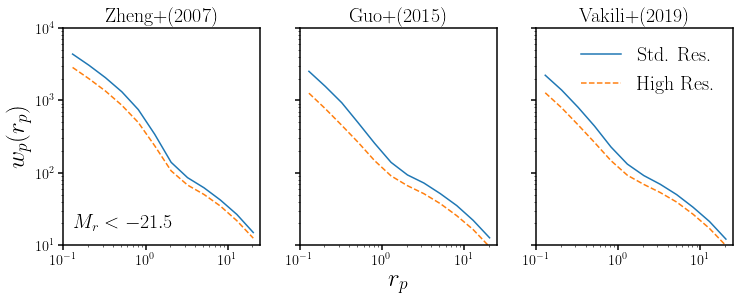

In [8]:
fig = plt.figure(figsize=(12,4))
for i, hod, lbl in zip(range(3), [z07_21_5, g15_21_5, v19_21_5], ['Zheng+(2007)', 'Guo+(2015)', 'Vakili+(2019)']): 
    sub = fig.add_subplot(1,3,i+1)
    
    wp_lr = wp_model(halos, hod, rsd=True) # low res
    wp_hr = wp_model(halos_hires, hod, rsd=True) # high res 
    
    sub.plot(0.5*(rbins[1:]+rbins[:-1]), wp_lr, c='C0', label='Std. Res.')
    sub.plot(0.5*(rbins[1:]+rbins[:-1]), wp_hr, c='C1', ls='--', label='High Res.' )
    
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    sub.set_yscale('log') 
    sub.set_ylim(1e1, 1e4) 
    sub.set_title(lbl, fontsize=20)
    if i != 0: sub.set_yticklabels([])
    else: sub.text(0.05, 0.05, r'$M_r < -21.5$', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)

    if i == 2: sub.legend(loc='upper right', fontsize=20)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel('$w_p(r_p)$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

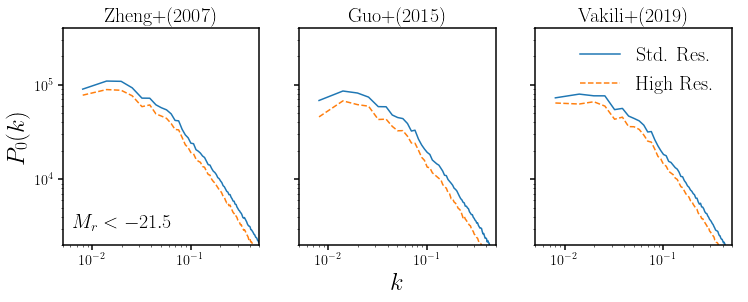

In [9]:
fig = plt.figure(figsize=(12,4))
for i, hod, lbl in zip(range(3), [z07_21_5, g15_21_5, v19_21_5], ['Zheng+(2007)', 'Guo+(2015)', 'Vakili+(2019)']): 
    sub = fig.add_subplot(1,3,i+1)
    
    k, pk_lr = pk_model(halos, hod, rsd=True) # low res
    k, pk_hr = pk_model(halos_hires, hod, rsd=True) # high res 
    
    sub.plot(k, pk_lr, c='C0', label='Std. Res.')
    sub.plot(k, pk_hr, c='C1', ls='--', label='High Res.' )
    
    sub.set_xscale('log') 
    sub.set_xlim(5e-3, 0.5) 
    sub.set_yscale('log') 
    sub.set_ylim(2e3, 4e5) 
    sub.set_title(lbl, fontsize=20)
    if i != 0: sub.set_yticklabels([])
    else: sub.text(0.05, 0.05, r'$M_r < -21.5$', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)
    if i == 2: sub.legend(loc='upper right', fontsize=20)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel('$P_0(k)$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

The halo mass limit in the standard resolution simulation removes central galaxies that would've been in lower mass halos. This messes up the bias of the clustering. Lets see how the $M_r < -22.0$ SDSS sample best-fit HOD does. 

(2000.0, 400000.0)

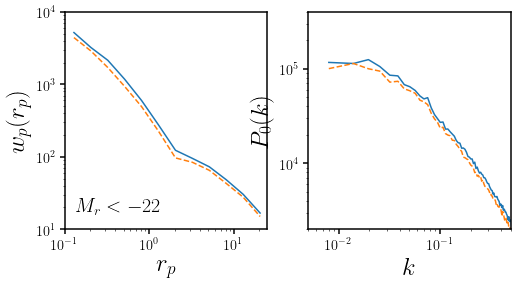

In [10]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(121)

wp_lr = wp_model(halos, z07_22_0, rsd=True) # low res
wp_hr = wp_model(halos_hires, z07_22_0, rsd=True) # high res 

sub.plot(0.5*(rbins[1:]+rbins[:-1]), wp_lr, c='C0', label='Std. Res.')
sub.plot(0.5*(rbins[1:]+rbins[:-1]), wp_hr, c='C1', ls='--', label='High Res.' )
sub.set_xlabel('$r_p$', fontsize=25) 
sub.set_ylabel('$w_p(r_p)$', fontsize=25) 
sub.set_xscale('log') 
sub.set_xlim(1e-1, 25) 
sub.set_yscale('log') 
sub.set_ylim(1e1, 1e4) 
sub.text(0.05, 0.05, r'$M_r < -22$', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)

sub = fig.add_subplot(122)

k, pk_lr = pk_model(halos, z07_22_0, rsd=True) # low res
k, pk_hr = pk_model(halos_hires, z07_22_0, rsd=True) # high res 

sub.plot(k, pk_lr, c='C0', label='Std. Res.')
sub.plot(k, pk_hr, c='C1', ls='--', label='High Res.' )
sub.set_xlabel('$k$', fontsize=25) 
sub.set_ylabel('$P_0(k)$', fontsize=25) 
sub.set_xscale('log') 
sub.set_xlim(5e-3, 0.5) 
sub.set_yscale('log') 
sub.set_ylim(2e3, 4e5) 

In [12]:
print(np.median(pk_lr/pk_hr))

1.1881543892740607


The bias is less affected bny the halo mass limit in the $M_r < -22.$ SDSS sample best-fit. However, there is still a significant effect (~20% difference in amplitude). This means that even though the HOD will be less representative of a "naturally" observable sample, we will have to reduce $\sigma_{\log M}$

(0.01, 50.0)

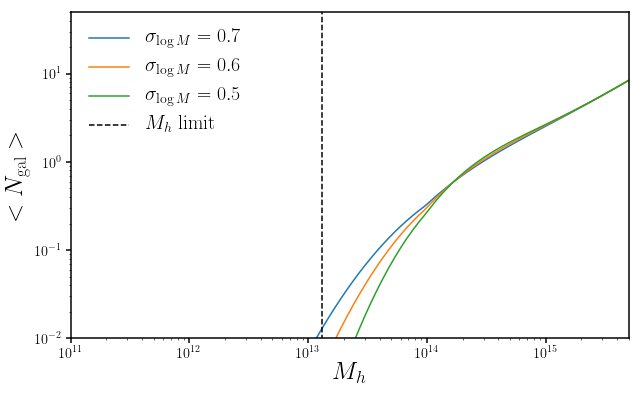

In [15]:
logMbin = np.linspace(11., 16., 100) # logMh bins

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
for i, sig in enumerate([0.7, 0.6, 0.5]): 
    tt_hod = np.array([14.22, sig, 14.00, 0.87, 14.69])
    sub.plot(10**logMbin, Ngal_Mh(tt_hod, logMbin), label=r'$\sigma_{\log M} = %.1f$' % sig)
sub.plot([10**Mh_min, 10**Mh_min], [1e-3, 1e3], c='k', ls='--', label='$M_h$ limit')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('$M_h$', fontsize=25)
sub.set_xscale('log')
sub.set_xlim(1e11, 5e15)
sub.set_ylabel(r'$<N_{\rm gal}>$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e-2, 5e1)

1.1071897947938818
1.0096105316125659
1.0105183358223355


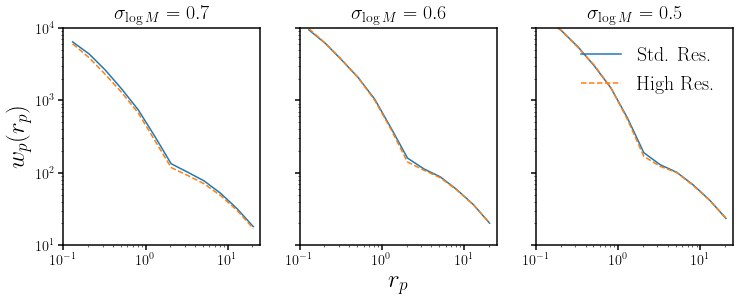

In [20]:
fig = plt.figure(figsize=(12,4))

for i, sig in enumerate([0.7, 0.6, 0.5]): 
    tt_hod = np.array([14.22, sig, 14.00, 0.87, 14.69])
    
    wps_lr, wps_hr = [], []
    for _ii in range(5): 
        _wp_lr = wp_model(halos, tt_hod, rsd=True, seed=_ii) # low res
        _wp_hr = wp_model(halos_hires, tt_hod, rsd=True, seed=_ii) # high res 
        wps_lr.append(_wp_lr)
        wps_hr.append(_wp_hr)
    wp_lr = np.average(wps_lr, axis=0)
    wp_hr = np.average(wps_hr, axis=0)
    print(np.median(wp_lr / wp_hr))
    
    sub = fig.add_subplot(1,3,i+1)
    sub.plot(0.5*(rbins[1:]+rbins[:-1]), wp_lr, c='C0', label='Std. Res.')
    sub.plot(0.5*(rbins[1:]+rbins[:-1]), wp_hr, c='C1', ls='--', label='High Res.' )
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    sub.set_yscale('log') 
    sub.set_ylim(1e1, 1e4) 
    sub.set_title(r'$\sigma_{\log M} = %.1f$' % sig, fontsize=20)
    if i != 0: sub.set_yticklabels([])
    if i == 2: sub.legend(loc='upper right', fontsize=20)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel('$w_p(r_p)$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

1.1295493454473444
1.0123872598508885
0.9965701554991058


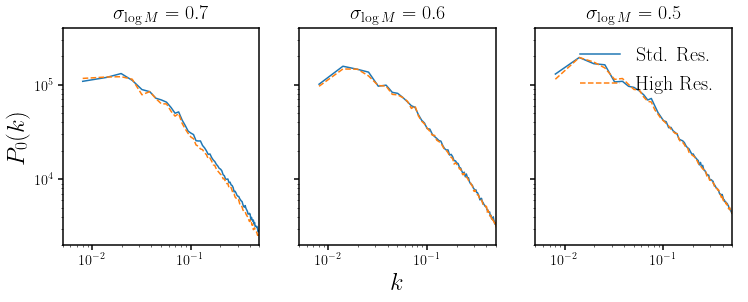

In [21]:
fig = plt.figure(figsize=(12,4))
for i, sig in enumerate([0.7, 0.6, 0.5]): 
    tt_hod = np.array([14.22, sig, 14.00, 0.87, 14.69])
    
    pks_lr, pks_hr = [], []
    for _ii in range(2): 
        k, _pk_lr = pk_model(halos, tt_hod, rsd=True, seed=_ii) # low res
        k, _pk_hr = pk_model(halos_hires, tt_hod, rsd=True, seed=_ii) # high res 
        pks_lr.append(_pk_lr)
        pks_hr.append(_pk_hr)
    pk_lr = np.average(pks_lr, axis=0)
    pk_hr = np.average(pks_hr, axis=0)
    
    sub = fig.add_subplot(1,3,i+1)
    sub.plot(k, pk_lr, c='C0', label='Std. Res.')
    sub.plot(k, pk_hr, c='C1', ls='--', label='High Res.' )
    print(np.median(pk_lr / pk_hr))
    sub.set_xscale('log') 
    sub.set_xlim(5e-3, 0.5) 
    sub.set_yscale('log') 
    sub.set_ylim(2e3, 4e5) 
    sub.set_title(r'$\sigma_{\log M} = %.1f$' % sig, fontsize=20)
    if i != 0: sub.set_yticklabels([])
    if i == 2: sub.legend(loc='upper right', fontsize=20)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel('$P_0(k)$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

The halo mass limit has little impact of the clustering for $\sigma_{\log M} < 0.6$. Hence a sensible choicse for our fiducial HOD parameters would be something like: 

$\log M_{\rm min} = 14.22$

$\sigma_{\log M} = 0.55$ 

$\log M_0 = 14.00$

$\alpha = 0.87$

$\log M_1 = 14.69$

## to-do
- run with multiple realizations to reduce noise